In [2]:
import matplotlib.pylab as plt

# first import tidy3d, its adjoint plugin, numpy, and jax.
import tidy3d as td
import tidy3d.plugins.adjoint as tda
import numpy as np
import jax.numpy as jnp
import jax

np.random.seed(2)

### Parameters

In [3]:
# wavelength and frequency
wavelength = 1.55
freq0 = td.C_0 / wavelength
k0 = 2 * np.pi * freq0 / td.C_0

# resolution control
min_steps_per_wvl = 16
dl_design_region = 0.01

# space between box and PML
buffer = 1.0 * wavelength

# optimized region size
lx = 4.0
ly = 4.0
lz = td.inf

# position of source and monitor
spacing = 2
source_x = -lx/2 - buffer*0.8
meas_x = lx/2 + buffer*0.8
meas_y1 = ly/2 - spacing/2
meas_y2 = -ly/2 + spacing/2

# total size
Lx = lx + 2*buffer
Ly = ly + 2*buffer
Lz = 0

# permittivity and width of the waveguide
eps_wg = 2.75
wg_width = 0.7
wg_length = 2

# random starting parameters between 0 and 1
nx = int(lx / dl_design_region)
ny = int(ly / dl_design_region)
param0 = np.random.random((nx, ny))

# freqency width and runtim
freqw = freq0 / 10
run_time = 50 / freqw

### Waveguid components

In [4]:
wg_in = td.Structure(
    geometry = td.Box(
        center=(-Lx/2, 0, 0),
        size = (wg_length *2, wg_width, lz),
    ), 
    medium=td.Medium(permittivity=eps_wg)
)

wg_top = td.Structure(
    geometry= td.Box(
        center=(+Lx/2, meas_y1, 0),
        size=(wg_length*2, wg_width, lz),
    ),
    medium = td.Medium(permittivity=eps_wg)
)

wg_bot = td.Structure(
    geometry=td.Box(
        center = (+Lx/2, meas_y2, 0),
        size=(wg_length*2, wg_width, lz)
    ),
    medium= td.Medium(permittivity=eps_wg)
)

mode_size = (0, wg_width*3, lz)

source_plane = td.Box(
    center=[source_x, 0, 0], 
    size = mode_size,
)

meas_plane_1 = td.Box(
    center = [meas_x, meas_y1, 0],
    size = mode_size,
)

meas_plane_2 = td.Box(
    center = [meas_x, meas_y2, 0],
    size = mode_size,
)

### Jax input structure

In [5]:
from tidy3d.plugins.adjoint.utils.filter import ConicFilter, BinaryProjector
from tidy3d.plugins.adjoint import JaxSimulation, JaxBox, JaxCustomMedium, JaxStructure, JaxStructureStaticGeometry
from tidy3d.plugins.adjoint import JaxSimulationData, JaxDataArray, JaxPermittivityDataset
from typing import List

radius = .120
beta = 50

conic_filter = ConicFilter(radius=radius, design_region_dl=float(lx)/nx)

def filter_project(params, beta, eta = 0.5):
    params_smooth = conic_filter.evaluate(params)
    binary_projector = BinaryProjector(vmin= 0, vmax=1, beta=beta, eta = eta)
    params_smooth_binarized = binary_projector.evaluate(params_smooth)
    return params_smooth_binarized

def get_eps(params, beta):
    """Get the permittivity values (1, eps_wg) array as a funciton of the parameters (0, 1)"""
    processed_params = filter_project(params, beta)
    return 1 + processed_params * (eps_wg - 1)

def make_input_structures(params, beta) -> List[JaxStructure]:

    x0_min = -lx / 2 + dl_design_region / 2
    y0_min = -ly / 2 + dl_design_region / 2

    input_structures = []

    coords_x = [x0_min + dl_design_region * ix for ix in range(nx)]
    coords_y = [y0_min + dl_design_region * iy for iy in range(ny)]

    coords = dict(x=coords_x, y=coords_y, z=[0], f=[freq0])

    eps = get_eps(params, beta=beta).reshape((nx, ny, 1, 1))

    field_components = {
        f"eps_{dim}{dim}": JaxDataArray(values=eps, coords=coords) for dim in "xyz"
    }
    eps_dataset = JaxPermittivityDataset(**field_components)
    custom_medium = JaxCustomMedium(eps_dataset=eps_dataset)
    box = td.Box(center=(0, 0, 0), size=(lx, ly, lz))
    custom_structure = JaxStructureStaticGeometry(geometry=box, medium=custom_medium)
    return [custom_structure]

### Jax Simulations

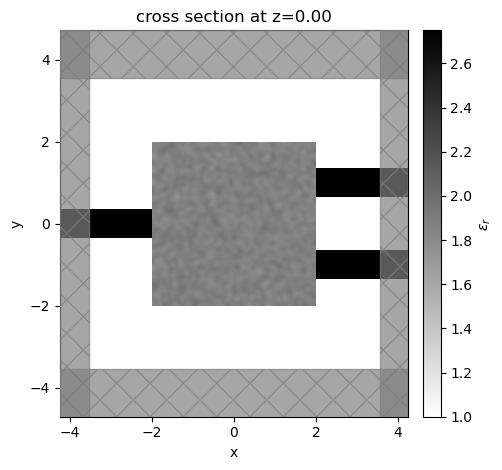

In [6]:
def make_sim_base(params, beta) -> JaxSimulation:

    input_structures = make_input_structures(params, beta=beta)
    design_region_mesh = td.MeshOverrideStructure(
        geometry=td.Box(size=(lx, ly, lz)),
        dl=[dl_design_region] * 3,
        enforce=True,
    )
    grid_spec=td.GridSpec.auto(
        wavelength=wavelength,
        min_steps_per_wvl=16,
        override_structures=[design_region_mesh],
    )

    return JaxSimulation(
        size=[Lx, Ly, Lz],
        grid_spec=grid_spec,
        structures=[wg_in, wg_top, wg_bot],
        input_structures=input_structures,
        sources=[],
        monitors=[],
        output_monitors=[],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
    )

sim_start = make_sim_base(param0, beta=1.0)

ax = sim_start.plot_eps(z=0)

plt.show()

### Mode Solver

In [7]:
from tidy3d.plugins.mode.web import run as run_mode_solver
from tidy3d.plugins.mode import ModeSolver

num_modes = 4
mode_spec = td.ModeSpec(num_modes=num_modes)

mode_solver = ModeSolver(
    simulation=sim_start.to_simulation()[0],
    plane=source_plane,
    mode_spec=td.ModeSpec(num_modes=num_modes),
    freqs=[freq0]
)
modes = run_mode_solver(mode_solver, reduce_simulation=True)
modes.to_dataframe()

21:50:24 CEST Mode solver created with                                          
              task_id='fdve-8de45d96-110f-46f6-a36a-9c528ab8f237',              
              solver_id='mo-d486f399-95d9-45d7-b7f3-341973cf1231'.

Output()

Output()

21:50:34 CEST Mode solver status: queued

21:50:36 CEST Mode solver status: running

21:50:42 CEST Mode solver status: success

Output()

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  1.498963    0.0      3.859053e-15   
             1                 1.55  1.403414    0.0      1.000000e+00   
             2                 1.55  1.026177    0.0      1.000000e+00   
             3                 1.55  1.020317    0.0      4.994229e-09   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 1.000000        0.878229   0.787092  
             1                 0.763086        1.000000   1.135187  
             2                 0.936160        1.000000   1.674033  
             3                 1.000000        0.563818   1.225445

### Plot modes

Effective index of computed modes:  [[1.4989629 1.4034139 1.026177  1.020317 ]]


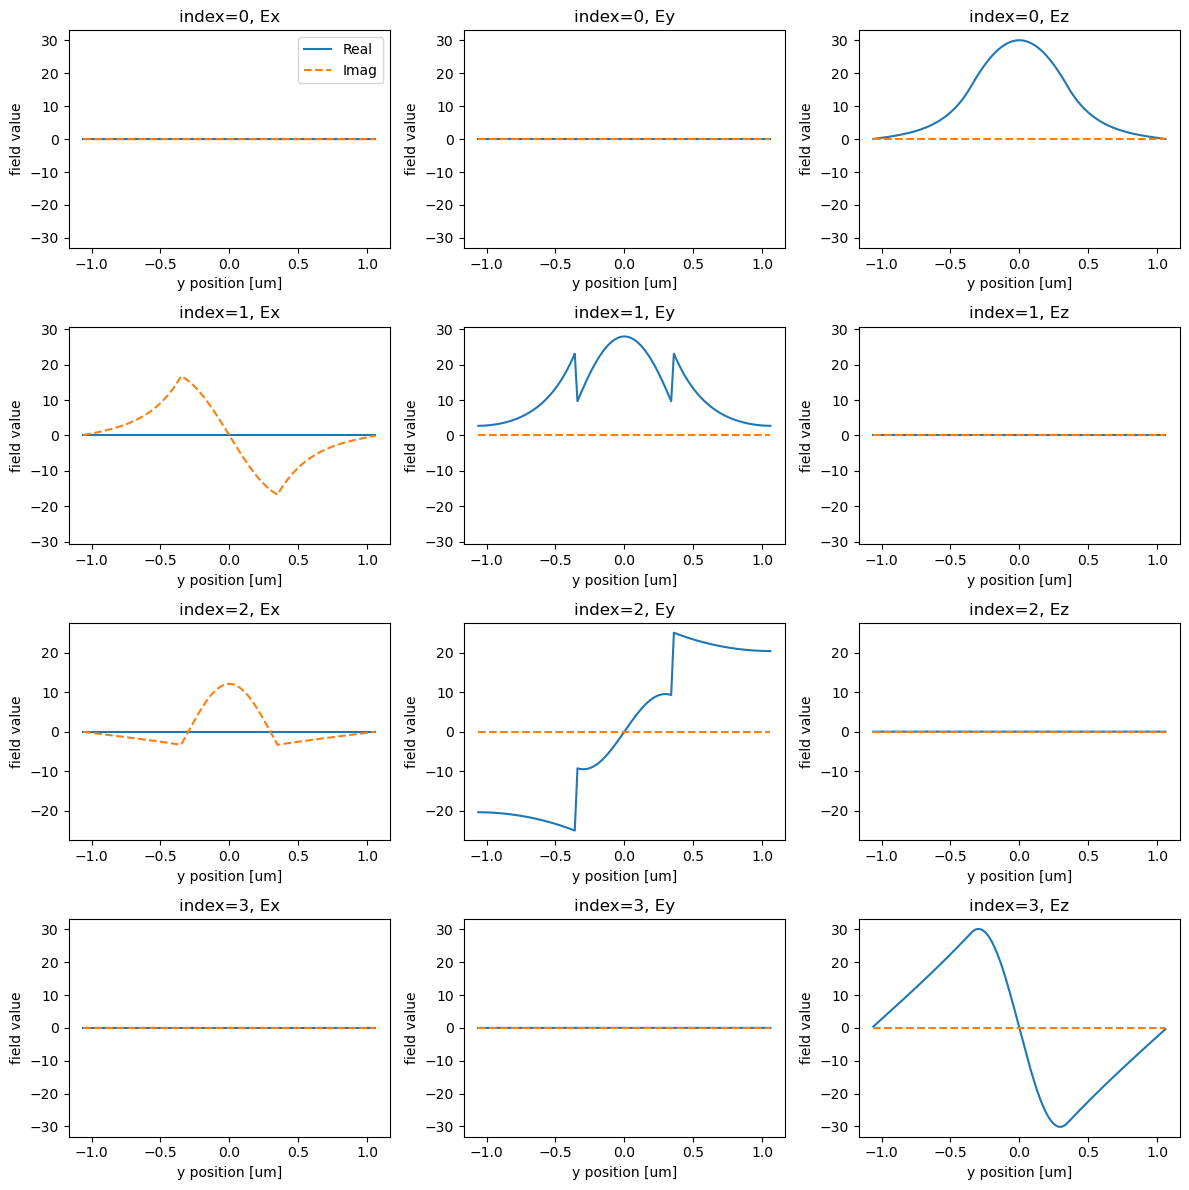

In [8]:
fig, axs = plt.subplots(num_modes, 3, figsize=(12, 12), tight_layout=True)
for mode_index in range(num_modes):
    vmax = 1.1 * max(abs(modes.field_components[n].sel(mode_index=mode_index)).max() for n in ("Ex", "Ey", "Ez"))
    for field_name, ax in zip(("Ex", "Ey", "Ez"), axs[mode_index]):
        field = modes.field_components[field_name].sel(mode_index=mode_index)
        field.real.plot(label="Real", ax=ax)
        field.imag.plot(ls="--", label="Imag", ax=ax)
        ax.set_title(f'index={mode_index}, {field_name}')
        ax.set_ylim(-vmax, vmax)

axs[0, 0].legend()

print("Effective index of computed modes: ", np.array(modes.n_eff))

### Field monitor and mode monitors

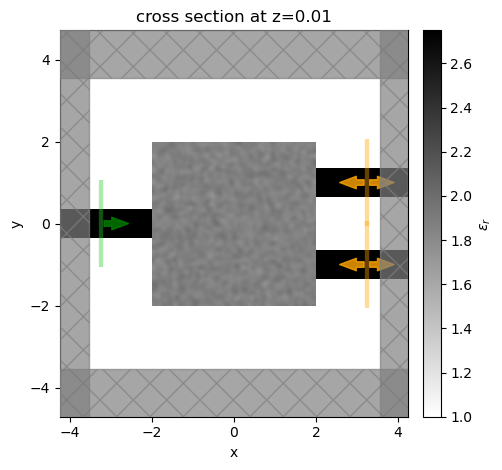

In [10]:
mode_index_out1 = 0
mode_index_out2 = 1

num_modes = max(mode_index_out1, mode_index_out2) + 1

mode_spec = td.ModeSpec(num_modes=num_modes)

# source seeding the simulation
mode_source = td.ModeSource(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
    center=[source_x, 0, 0],
    size=mode_size,
    mode_index=0,
    mode_spec=mode_spec,
    direction="+",
)


mnt_top = td.ModeMonitor(
    center = meas_plane_1.center,
    size = mode_size,
    freqs=[freq0],
    mode_spec= mode_spec,
    name = "mode_top",
)

mnt_bot = td.ModeMonitor(
    center = meas_plane_2.center,
    size = mode_size,
    freqs=[freq0],
    mode_spec= mode_spec,
    name = "mode_bot",
)

field_mnt = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field_mnt",
    colocate=False,
)

def make_sim(params, beta):
    
    sim_base = make_sim_base(params, beta = beta)
    return sim_base.updated_copy(
        output_monitors = [mnt_top, mnt_bot, field_mnt],
        sources = [mode_source]
    )


sim = make_sim(param0, beta=1)
ax = sim.plot_eps(z=0.01)
plt.show()

### Objective function

In [13]:
from tidy3d.plugins.adjoint.utils.penalty import ErosionDilationPenalty

mnt_names = dict(top="mode_top", bot="mode_bot")

def measure_power(sim_data) -> float:
    """Extract power from simulation data."""

    def get_power(mnt_key: str, mode_in: int) -> float:
        mnt_name = mnt_names[mnt_key]
        mnt_data = sim_data[mnt_name]
        amp = mnt_data.amps.sel(direction="+", mode_index=mode_in, f=freq0)
        return jnp.abs(amp) ** 2

    power_max = get_power("top", 0) + get_power("bot", 1)
    return power_max / 2.0


def penalty(params, beta):
    processed_params = filter_project(params, beta=beta)

    ed_penalty = ErosionDilationPenalty(length_scale=radius, pixel_size=dl_design_region)
    return ed_penalty.evaluate(processed_params)


def J(params, beta: float, step_num: int = None, verbose: bool = False) -> float:
    sim = make_sim(params, beta=beta)
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = tda.web.run(sim, task_name=task_name, verbose=verbose)
    penalty_weight = np.minimum(1, beta/25)
    return measure_power(sim_data) - penalty_weight * penalty(params, beta)

In [14]:
def objective(params, beta, verbose=False) -> float:
    sim = make_sim(params, beta=beta)
    sim_data = tda.web.run(sim, task_name="pol_splitter", verbose=verbose)
    power = measure_power(sim_data)
    J = power - penalty(params, beta=beta)
    return J, sim_data

grad_fn = jax.value_and_grad(objective, has_aux=True)
(J, sim_data), grad = grad_fn(param0, beta=1, verbose=True)

22:27:12 CEST Created task 'pol_splitter' with task_id                          
              'fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=645270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=628419;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\taskId]8;;\]8;id=645270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\=]8;;\]8;id=526356;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\fdve]8;;\]8;id=645270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\-9c72f91a-88]8;;\
              ]8;id=645270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\36-46d3-bac9-0fe3a8c2136c']8;;\.

Output()

Output()

22:27:28 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

22:27:35 CEST status = preprocess

22:27:37 CEST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

22:27:43 CEST early shutoff detected at 8%, exiting.

              status = postprocess

Output()

22:28:01 CEST status = success

22:28:02 CEST View simulation result at                                         
              ]8;id=80792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=999835;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\taskId]8;;\]8;id=80792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\=]8;;\]8;id=295184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\fdve]8;;\]8;id=80792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\-9c72f91a-88]8;;\
              ]8;id=80792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c72f91a-8836-46d3-bac9-0fe3a8c2136c\36-46d3-bac9-0fe3a8c2136c']8;;\.

Output()

22:28:14 CEST loading simulation from simulation_data.hdf5

22:28:21 CEST Created task 'pol_splitter_adj' with task_id                      
              'fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=509258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=753662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\taskId]8;;\]8;id=509258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\=]8;;\]8;id=16465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\fdve]8;;\]8;id=509258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\-790e1b3e-ac]8;;\
              ]8;id=509258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\f0-4dd6-bea4-009cb3a719f5']8;;\.

Output()

Output()

22:28:32 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

22:28:38 CEST status = preprocess

22:28:39 CEST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

22:28:45 CEST early shutoff detected at 8%, exiting.

              status = postprocess

Output()

22:28:52 CEST status = success

22:28:53 CEST View simulation result at                                         
              ]8;id=702060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=151526;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\taskId]8;;\]8;id=702060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\=]8;;\]8;id=941053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\fdve]8;;\]8;id=702060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\-790e1b3e-ac]8;;\
              ]8;id=702060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-790e1b3e-acf0-4dd6-bea4-009cb3a719f5\f0-4dd6-bea4-009cb3a719f5']8;;\.

Output()

### Optimization

In [15]:
import optax

# we know that the source fwidth will be set automatically due to multi-freq adjoint, so suppress warnings
td.config.logging_level = "ERROR"

# hyperparameters
num_steps = 20
learning_rate = 1
beta_min = 1
beta_max = 30

# initialize adam optimizer with starting parameters
params = param0
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
Js = []
params_history = [param0]
data_history = []
beta_history = []

for i in range(num_steps):

    perc_done = i / (num_steps - 1)
    beta_i = beta_min * (1 - perc_done) + beta_max * perc_done
    
    # compute gradient and current objective funciton value
    (value, data), gradient = grad_fn(params, beta=beta_i)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tbeta = {beta_i:.2f}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # keep params between 0 and 1
    params = jnp.minimum(1.0, params)
    params = jnp.maximum(0.0, params)

    # save history
    Js.append(value)
    params_history.append(params)
    beta_history.append(beta_i)
    data_history.append(data)

step = 1
	J = -9.1521e-01
	beta = 1.00
	grad_norm = 5.2917e-03
step = 2
	J = 4.5066e-02
	beta = 2.53
	grad_norm = 1.2606e-02
step = 3
	J = 1.8940e-01
	beta = 4.05
	grad_norm = 5.5916e-03
step = 4
	J = 2.8027e-01
	beta = 5.58
	grad_norm = 4.0381e-03
step = 5
	J = 3.5345e-01
	beta = 7.11
	grad_norm = 2.4470e-03
step = 6
	J = 3.9504e-01
	beta = 8.63
	grad_norm = 1.5340e-03
step = 7
	J = 4.1913e-01
	beta = 10.16
	grad_norm = 1.2527e-03
step = 8
	J = 4.3553e-01
	beta = 11.68
	grad_norm = 1.5100e-03
step = 9
	J = 4.5143e-01
	beta = 13.21
	grad_norm = 1.6857e-03
step = 10
	J = 4.6127e-01
	beta = 14.74
	grad_norm = 6.8598e-04
step = 11
	J = 4.6648e-01
	beta = 16.26
	grad_norm = 5.9447e-04
step = 12
	J = 4.7002e-01
	beta = 17.79
	grad_norm = 5.1699e-04
step = 13
	J = 4.7240e-01
	beta = 19.32
	grad_norm = 4.3985e-04
step = 14
	J = 4.7312e-01
	beta = 20.84
	grad_norm = 4.3786e-03
step = 15
	J = 4.7497e-01
	beta = 22.37
	grad_norm = 3.6059e-04
step = 16
	J = 4.7558e-01
	beta = 23.89
	grad_norm = 3

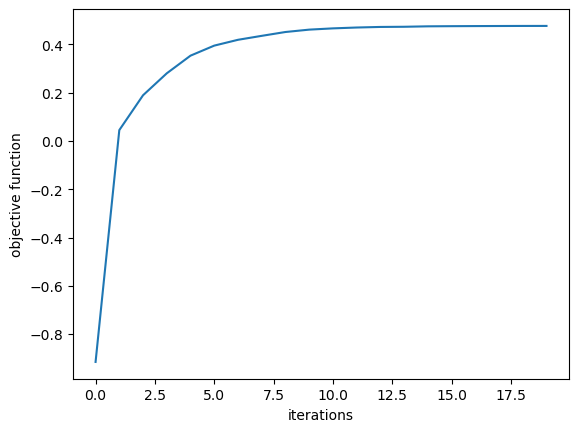

In [16]:
plt.plot(Js)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.show()

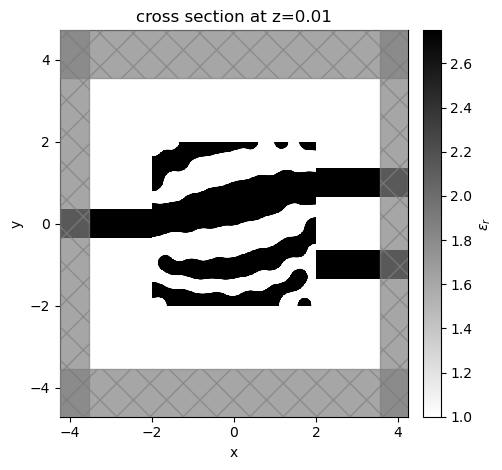

In [17]:
sim_data_final = data_history[-1]
sim_final = sim_data_final.simulation
ax = sim_final.plot_eps(z=0.01, monitor_alpha=0, source_alpha=0)

In [29]:
# plot fields at the two design wavelengths

# fig, axes = plt.subplots(1, 2, tight_layout=True, figsize=(7, 3))

int_i = sim_data_final.get_intensity("field_mnt").sel(f = freq0)
# int_i.squeeze().plot.pcolormesh(x='x', y='y', ax=ax, add_colorbar=False, cmap="magma", vmax=1000)

# sim_data_final.plot_field("field_mnt", "E", "abs^2", z=0)
print(int_i.squeeze())

# for key, ax in zip(("top", "bot"), axes):
#     sim_data_final.plot_field("field", "E", "abs^2", mode_index = , ax=ax, vmax=1200)
#     mode = ["TE", "TM"]
#     ax.set_title(mode[key])

attrs={} values=Array([[0.00000000e+00, 4.53103165e-56, 9.02704442e-51, ...,
        4.60656062e-55, 9.28002787e-61, 0.00000000e+00],
       [1.49429329e-56, 1.38496410e-51, 1.11308513e-34, ...,
        1.06991875e-50, 2.21800777e-56, 4.64001425e-61],
       [1.60502580e-52, 1.00936017e-36, 3.12109737e-31, ...,
        5.90697391e-35, 1.09423799e-52, 1.56880044e-56],
       ...,
       [2.56710742e-55, 1.87171818e-50, 1.29556272e-34, ...,
        1.78048753e-50, 8.58369465e-56, 2.90000862e-60],
       [3.94401205e-60, 4.16008551e-55, 3.16498446e-50, ...,
        2.89049502e-55, 1.04400311e-60, 0.00000000e+00],
       [0.00000000e+00, 7.54002273e-60, 7.31846235e-55, ...,
        6.14801879e-60, 0.00000000e+00, 0.00000000e+00]], dtype=float64) coords={'x': [-4.2510138761433, -4.192596053131358, -4.134178230119416, -4.075760407107475, -4.017342584095533, -3.9589247610835914, -3.9005069380716497, -3.842089115059708, -3.7836712920477664, -3.7252534690358248, -3.666835646023883, -3.608417823